# Water Extent Detection using satellite imagery

![](images/img.png)

In [36]:
import rasterio as rio
import geopandas as gpd
from rasterio import features
from rasterio.plot import show
import matplotlib.pyplot as plt

## Reading the data

In [4]:
FILE_PATH = "./2018-04-06/"

# green band
B03 = rio.open(FILE_PATH + "B03.tiff")

# near infrared band
B08 = rio.open(FILE_PATH + "B08.tiff")

# true color image
TRUE_COLOR = rio.open(FILE_PATH + "True_color.tiff")

## Plotting the data for a quick preview

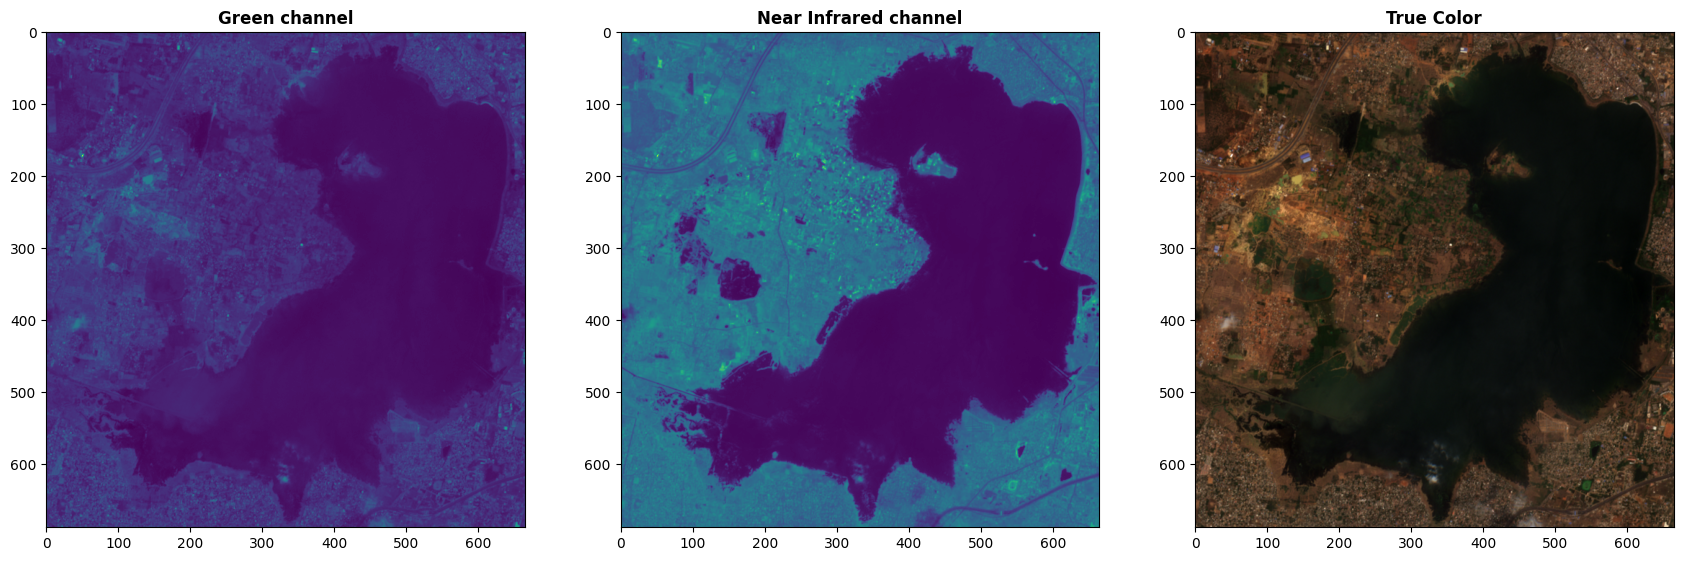

In [21]:
fig, (axg, axn, axrgb) = plt.subplots(1,3, figsize=(21,10))

show(B03.read(1), ax=axg, title='Green channel')
show(B08.read(1), ax=axn, title='Near Infrared channel')
show(TRUE_COLOR.read(), adjust=True, ax=axrgb, title='True Color');

## Estimate NDWI

The Normalized Difference Water Index (NDWI) is used to highlight open water features in a satellite image, allowing a water body to “stand out” against the soil and vegetation.
The NDWI, is calculated using the GREEN-NIR (visible green and near-infrared) combination, which allows it to detect subtle changes in water content of the water bodies.

The NDWI index was proposed by McFeeters in 1996. Its primary use today is to detect and monitor slight changes in water content of the water bodies. Taking advantage of the NIR (near-infrared) and GREEN (visible green) spectral bands, the NDWI is capable of enhancing the water bodies in a satellite image. The downside of the index is that it is sensitive to built structures, which can lead to overestimation of water bodies.

$$NDWI = (Green - NIR) / (Green + NIR)$$

In [22]:
ndwi = (B03.read().astype(float) - B08.read().astype(float)) / (B03.read() + B08.read())

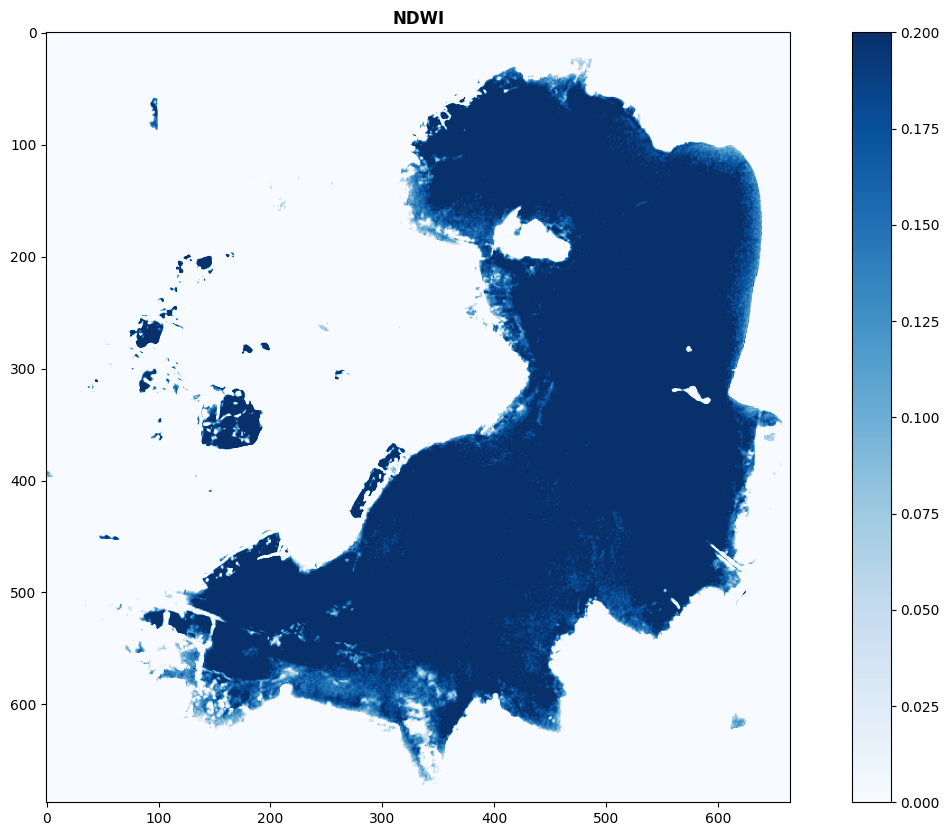

In [34]:
fig, (ax) = plt.subplots(1,1, figsize=(16,10))

img = show(ndwi, ax=ax, title='NDWI', cmap= 'Blues', vmin=0, vmax=0.2)
cbar = img.get_images()[0]
fig.colorbar(cbar, ax=ax);

## Generate Mask and features

In [52]:
ndwi_mask = ndwi[-1] > 0

shapes = ({'properties': {'raster_value': v}, 'geometry': s}
           for i, (s, v) in enumerate(features.shapes(ndwi_mask.astype('int16'), mask=ndwi_mask, transform=B03.transform)))

In [53]:
observed_boundary  = gpd.GeoDataFrame.from_features(list(shapes))

In [56]:
observed_boundary.crs = "EPSG:3857"

## Filter extracted shapes with the provided OSM polygon

In [57]:
actual_boundary = gpd.read_file("shape.geojson")

In [60]:
# run spatial inner join
filtered_boundary = gpd.sjoin(observed_boundary,actual_boundary, predicate="intersects", how="inner")

<Axes: >

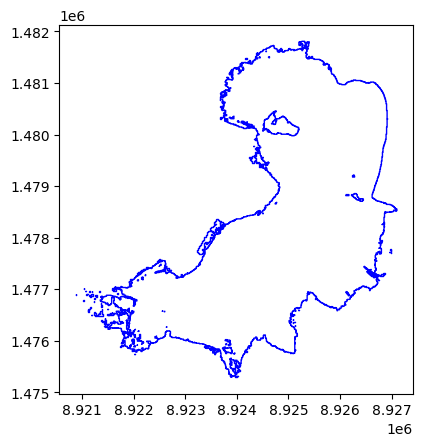

In [71]:
filtered_boundary.plot(facecolor='none', edgecolor='blue')

## Plot the extracted shapes over true color images

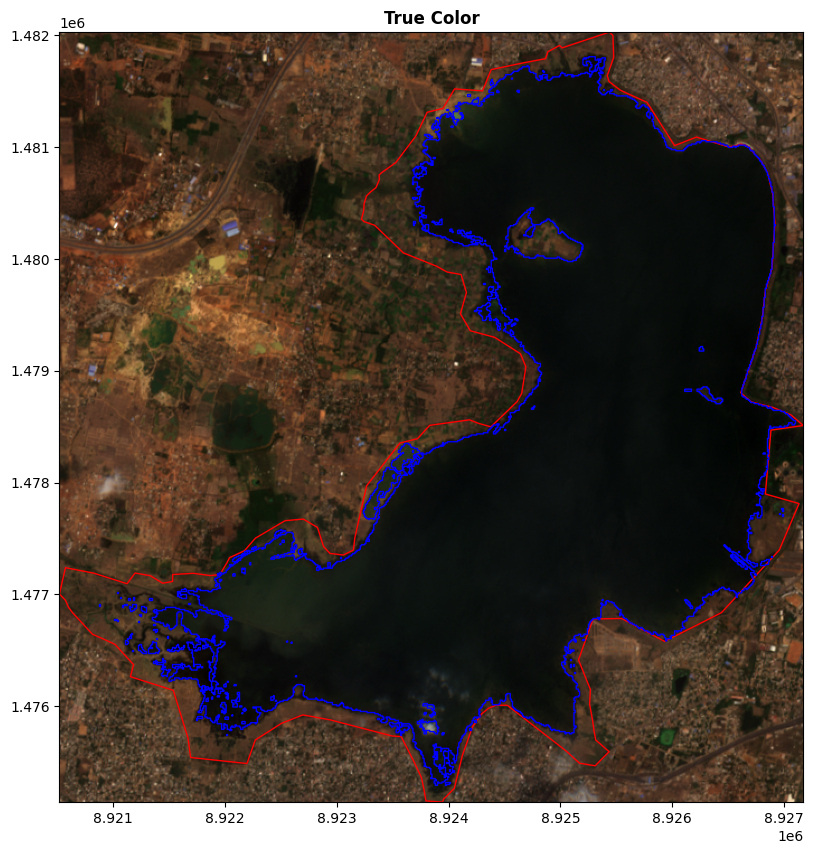

In [78]:
fig, ax = plt.subplots(figsize=(16, 10))
show(TRUE_COLOR.read(), transform=TRUE_COLOR.transform,adjust=True, ax=ax, title='True Color')
actual_boundary.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)
filtered_boundary.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1);

## Calculating Area of the extracted shapes

In [86]:
## Calculating Area of the extracted shapes
print(f"Area of observed shape {(filtered_boundary.geometry.area.sum() / 10**6).round(2)} km2")
print(f"Area of actual shape {(actual_boundary.geometry.area.sum() / 10**6).round(2)} km2")
print(f"Difference (km2) {((actual_boundary.geometry.area.sum() / 10**6) - (filtered_boundary.geometry.area.sum() / 10**6)).round(2)} km2")

Area of observed shape 16.69 km2
Area of actual shape 20.51 km2
Difference (km2) 3.82 km2
